In [1]:
import MQLib
import pickle
from pennylane import numpy as np
import networkit as nk
from networkit.algebraic import adjacencyMatrix

In [2]:
method_lists_old = ["std", "naive_wd", "orbit", "ma"]
method_lists_proposed = ["eigenbased_wd", "algebraic_dis"]
method_lists = ["std", "eigenbased_wd", "algebraic_dis", "naive_wd", "orbit", "ma"]

In [3]:
def solve_maxcut_problem_with_mqlib(adjacency_matrix: np.ndarray,
                                    solver_timeout: float = 0.5,
                                    solver_name: str = 'BURER2002',
                                    solver_seed = 42):

    dat = adjacency_matrix.copy()
    mqlib_instance = MQLib.Instance(problem="M",
                                    dat=dat)
    # MQLIB MAXIMIZES <x|Q|x> if QUBO is given.
    mqlib_result = MQLib.runHeuristic(heuristic=solver_name,
                                   instance=mqlib_instance,
                                   rtsec=solver_timeout,
                                   # TODO FBM: WHat is this helper function?
                                   cb_fun=lambda x: 1,
                                   seed=solver_seed)
    mqlib_result['solution'] = (1 - mqlib_result['solution']) / 2
    mqlib_result['solution'] = mqlib_result['solution'].astype(int)
    return mqlib_result

In [4]:
random_seed_list = [877, 892, 797, 416, 694]#, 351, 491, 950, 410, 38]

## Unweighted graphs

In [5]:
unweighted_obj = {}
for num_node in range(8, 14):
    unweighted_best_obj = [] 
    with open(f'graph_instances/Unweighted_graphs_n={num_node}.pkl', 'rb') as f:
        graph_set = pickle.load(f)
    for graph in graph_set:
        result = solve_maxcut_problem_with_mqlib(adjacency_matrix = adjacencyMatrix(graph).toarray())
        unweighted_best_obj.append(result['objval'])
    unweighted_obj[num_node] = unweighted_best_obj

In [6]:
unweighted_qaoa_result = {}
for num_node in range(8, 14):
    method_result = {}
    for method in method_lists:#method_lists_old + method_lists_proposed:
        method_result[method] = []
        for seed in random_seed_list:    
            with open(f'result/new_res/res_Unweighted_graphs_n={num_node}_seed={seed}.pkl', 'rb') as f:
                std_result = pickle.load(f)
            # with open(f'result/res_subset_Unweighted_graphs_n={num_node}_seed={seed}.pkl', 'rb') as f:
            #     proposed_result = pickle.load(f)
            # if method in method_lists_proposed:
            #     result_method = proposed_result[method]
            # else:
            result_method = std_result[method]
            obj_lst = [res[0] for res in result_method]
            num_params = [(res[1].shape[0]*res[1].shape[1]) + (res[2].shape[0]*res[2].shape[1])  for res in result_method]
            method_result[method].append([np.array(obj_lst) / np.array(unweighted_obj[num_node]), num_params])
    unweighted_qaoa_result[num_node] = method_result

In [7]:
unweighted_objvals = {}
unweighted_numparams = {}
for method in method_lists:#method_lists_old + method_lists_proposed:
    unweighted_objvals[method] = []
    unweighted_numparams[method] = []
    for num_node in range(8, 14):
        node_objvals = []
        node_numparams = []
        for seed_idx in range(len(random_seed_list)):
            node_objvals = np.concatenate((node_objvals, unweighted_qaoa_result[num_node][method][seed_idx][0]))
            node_numparams = np.concatenate((node_numparams, unweighted_qaoa_result[num_node][method][seed_idx][1]))
        unweighted_objvals[method].append([np.average(node_objvals), np.std(node_objvals)])
        unweighted_numparams[method].append([np.average(node_numparams), np.std(node_numparams)])

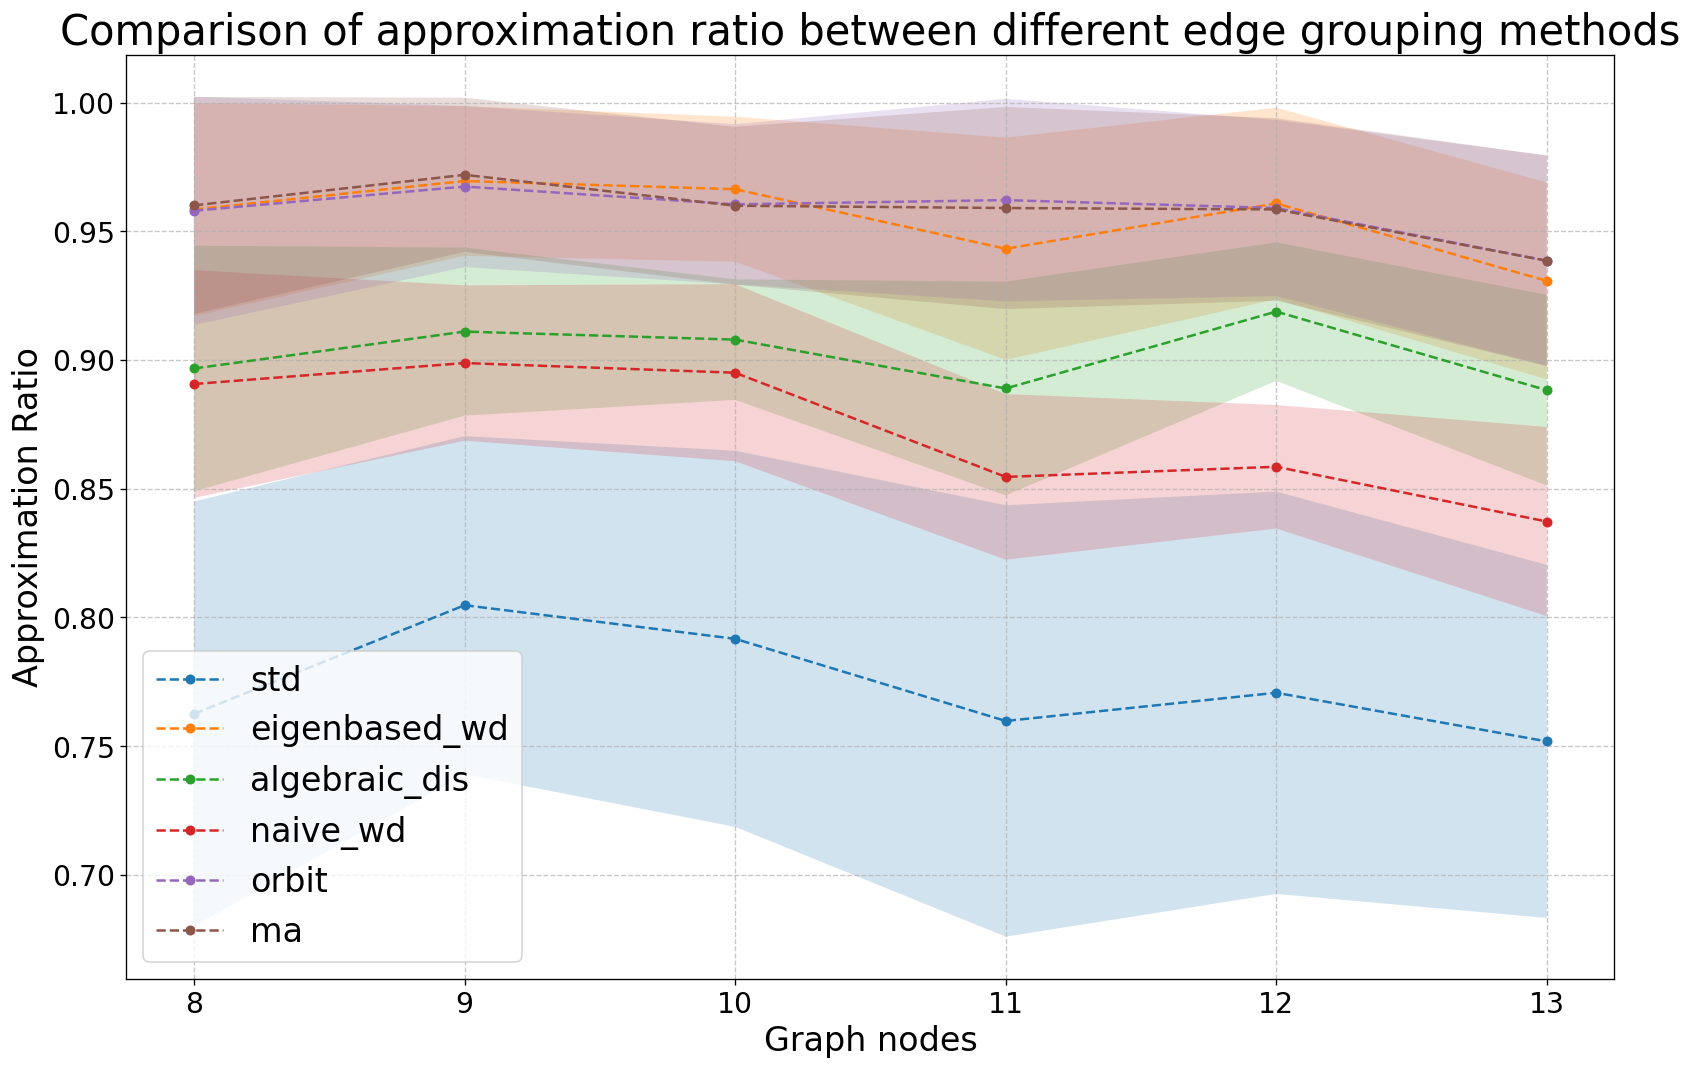

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists:#method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(unweighted_objvals[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)
    plt.fill_between(x, np.array(unweighted_objvals[method])[:,0]-np.array(unweighted_objvals[method])[:,1], np.array(unweighted_objvals[method])[:,0]+np.array(unweighted_objvals[method])[:,1],
    alpha=0.2, linewidth=4, linestyle='dashdot', antialiased=True)
# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Approximation Ratio', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
plt.title('Comparison of approximation ratio between different edge grouping methods', fontsize="25")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')

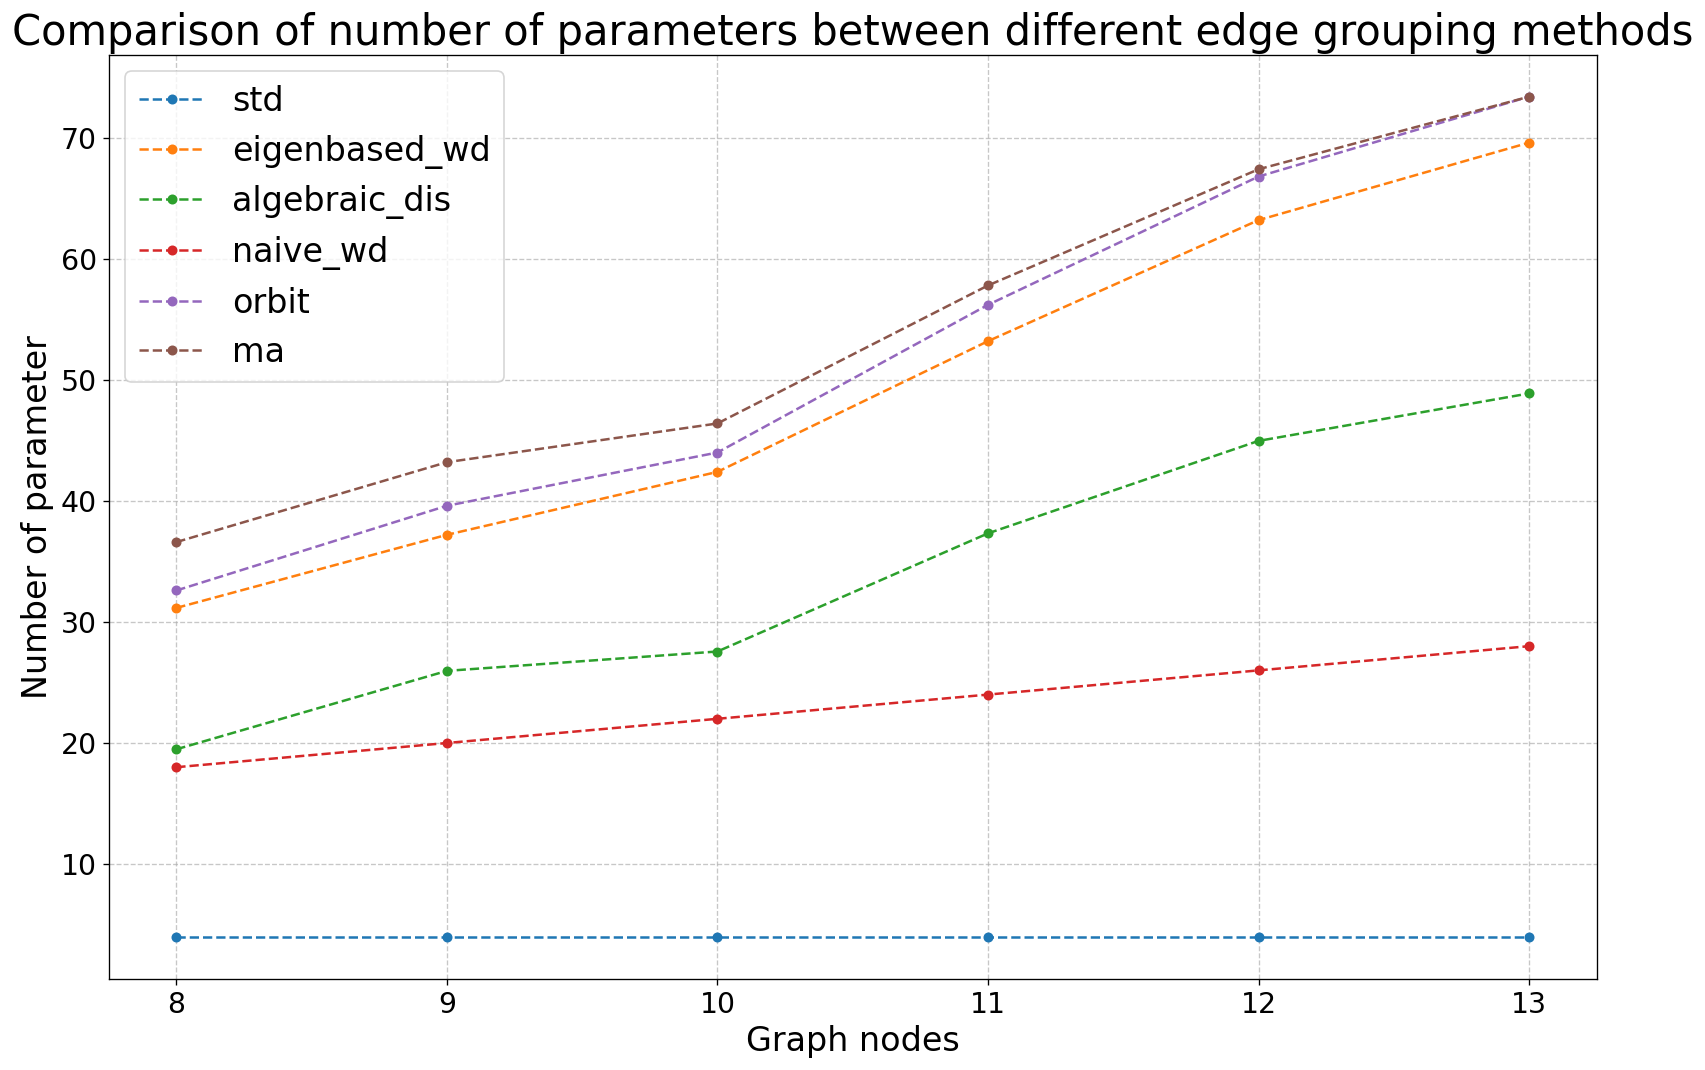

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists:#method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(unweighted_numparams[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)

# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Number of parameter', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
plt.title('Comparison of number of parameters between different edge grouping methods', fontsize="25")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')

## Random graphs and distributed 

In [5]:
random_weighted_obj = {}
for num_node in range(8, 14):
    random_weighted_best_obj = [] 
    with open(f'graph_instances/distributed_weighted_graphs_n={num_node}.pkl', 'rb') as f:
        graph_set = pickle.load(f)
    for graph in graph_set:
        result = solve_maxcut_problem_with_mqlib(adjacency_matrix = adjacencyMatrix(graph).toarray())
        random_weighted_best_obj.append(result['objval'])
    random_weighted_obj[num_node] = random_weighted_best_obj

In [6]:
random_weighted_qaoa_result = {}
for num_node in range(8, 14):
    method_result = {}
    for method in method_lists:#method_lists_old + method_lists_proposed:
        method_result[method] = []
        for seed in random_seed_list:    
            with open(f'result/new_res/res_distributed_weighted_graphs_n={num_node}_seed={seed}.pkl', 'rb') as f:
                std_result = pickle.load(f)
            # with open(f'result/res_subset_distributed_weighted_graphs_n={num_node}_seed={seed}.pkl', 'rb') as f:
            #     proposed_result = pickle.load(f)
            # if method in method_lists_proposed:
            #     result_method = proposed_result[method]
            # else:
            result_method = std_result[method]
            obj_lst = [res[0] for res in result_method]
            num_params = [(res[1].shape[0]*res[1].shape[1]) + (res[2].shape[0]*res[2].shape[1])  for res in result_method]
            method_result[method].append([np.array(obj_lst) / np.array(random_weighted_obj[num_node]), num_params])
    random_weighted_qaoa_result[num_node] = method_result

In [7]:
random_weighted_objvals = {}
random_weighted_numparams = {}
for method in method_lists:#method_lists_old + method_lists_proposed:
    random_weighted_objvals[method] = []
    random_weighted_numparams[method] = []
    for num_node in range(8, 14):
        node_objvals = []
        node_numparams = []
        for seed_idx in range(len(random_seed_list)):
            node_objvals = np.concatenate((node_objvals, random_weighted_qaoa_result[num_node][method][seed_idx][0]))
            node_numparams = np.concatenate((node_numparams, random_weighted_qaoa_result[num_node][method][seed_idx][1]))
        random_weighted_objvals[method].append([np.average(node_objvals), np.std(node_objvals)])
        random_weighted_numparams[method].append([np.average(node_numparams), np.std(node_numparams)])

#### Random result

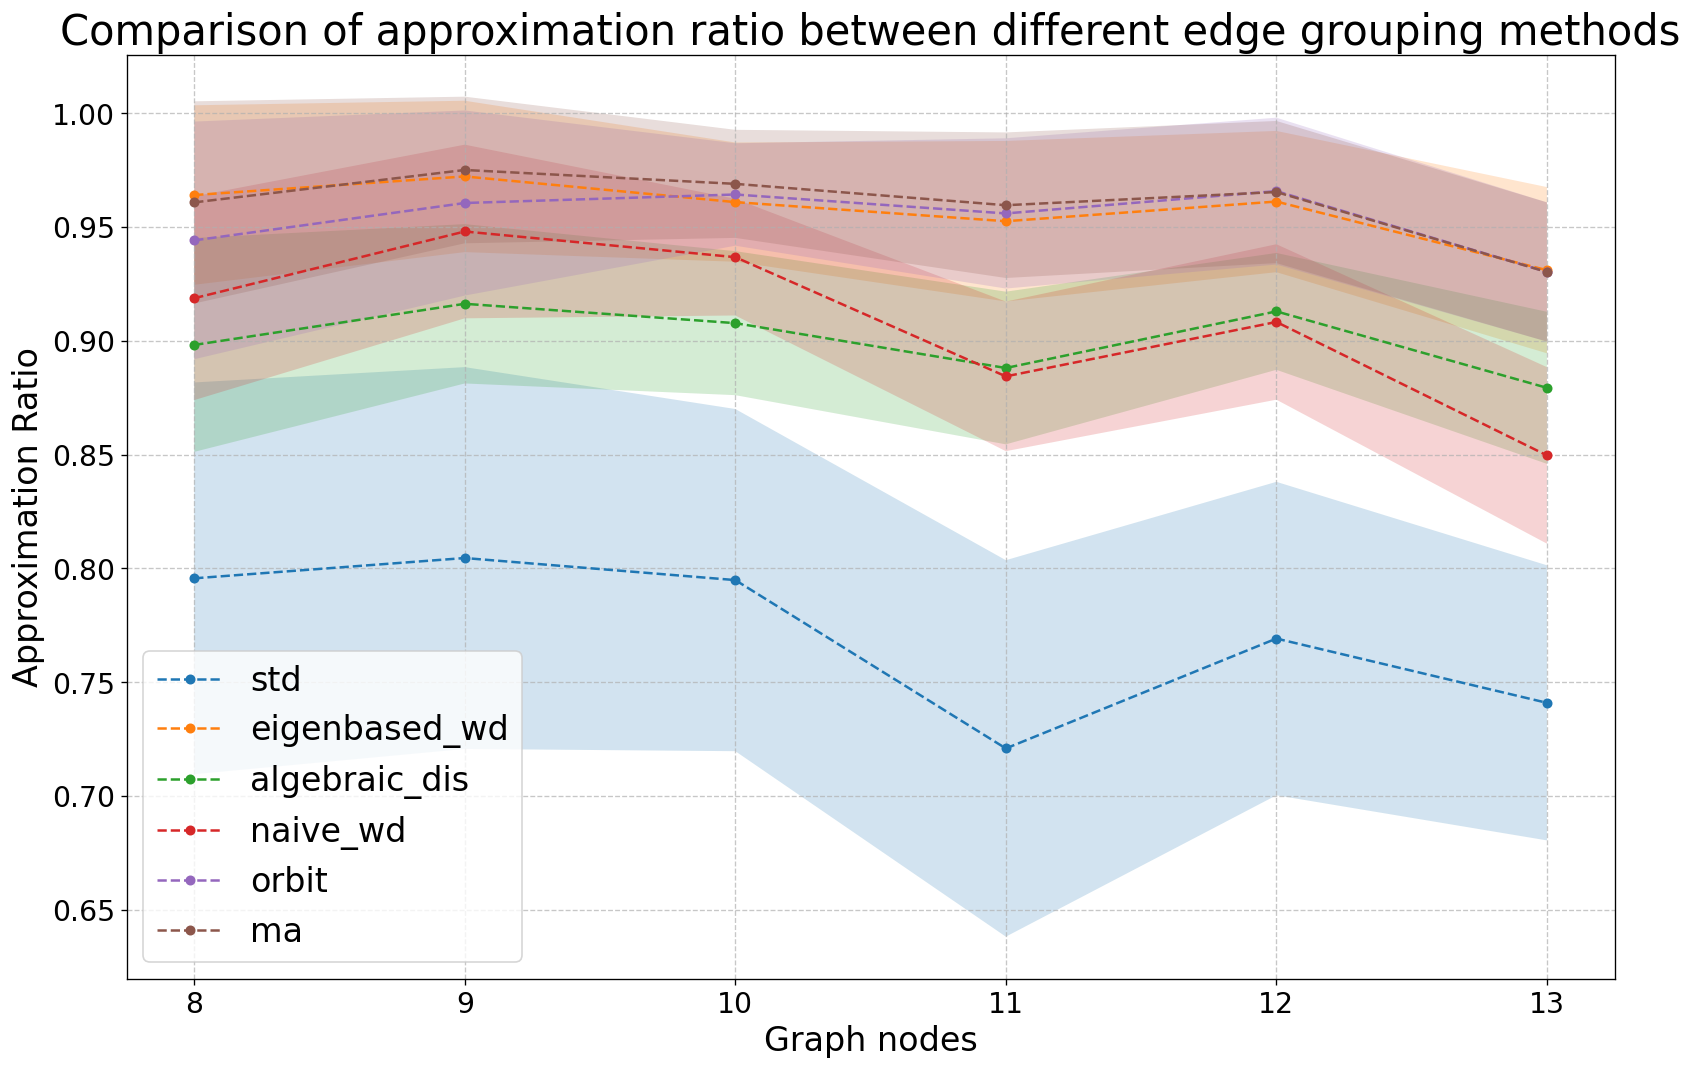

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists:#method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(random_weighted_objvals[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)
    plt.fill_between(x, np.array(random_weighted_objvals[method])[:,0]-np.array(random_weighted_objvals[method])[:,1], np.array(random_weighted_objvals[method])[:,0]+np.array(random_weighted_objvals[method])[:,1],
    alpha=0.2, linewidth=4, linestyle='dashdot', antialiased=True)
# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Approximation Ratio', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
plt.title('Comparison of approximation ratio between different edge grouping methods', fontsize="25")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')

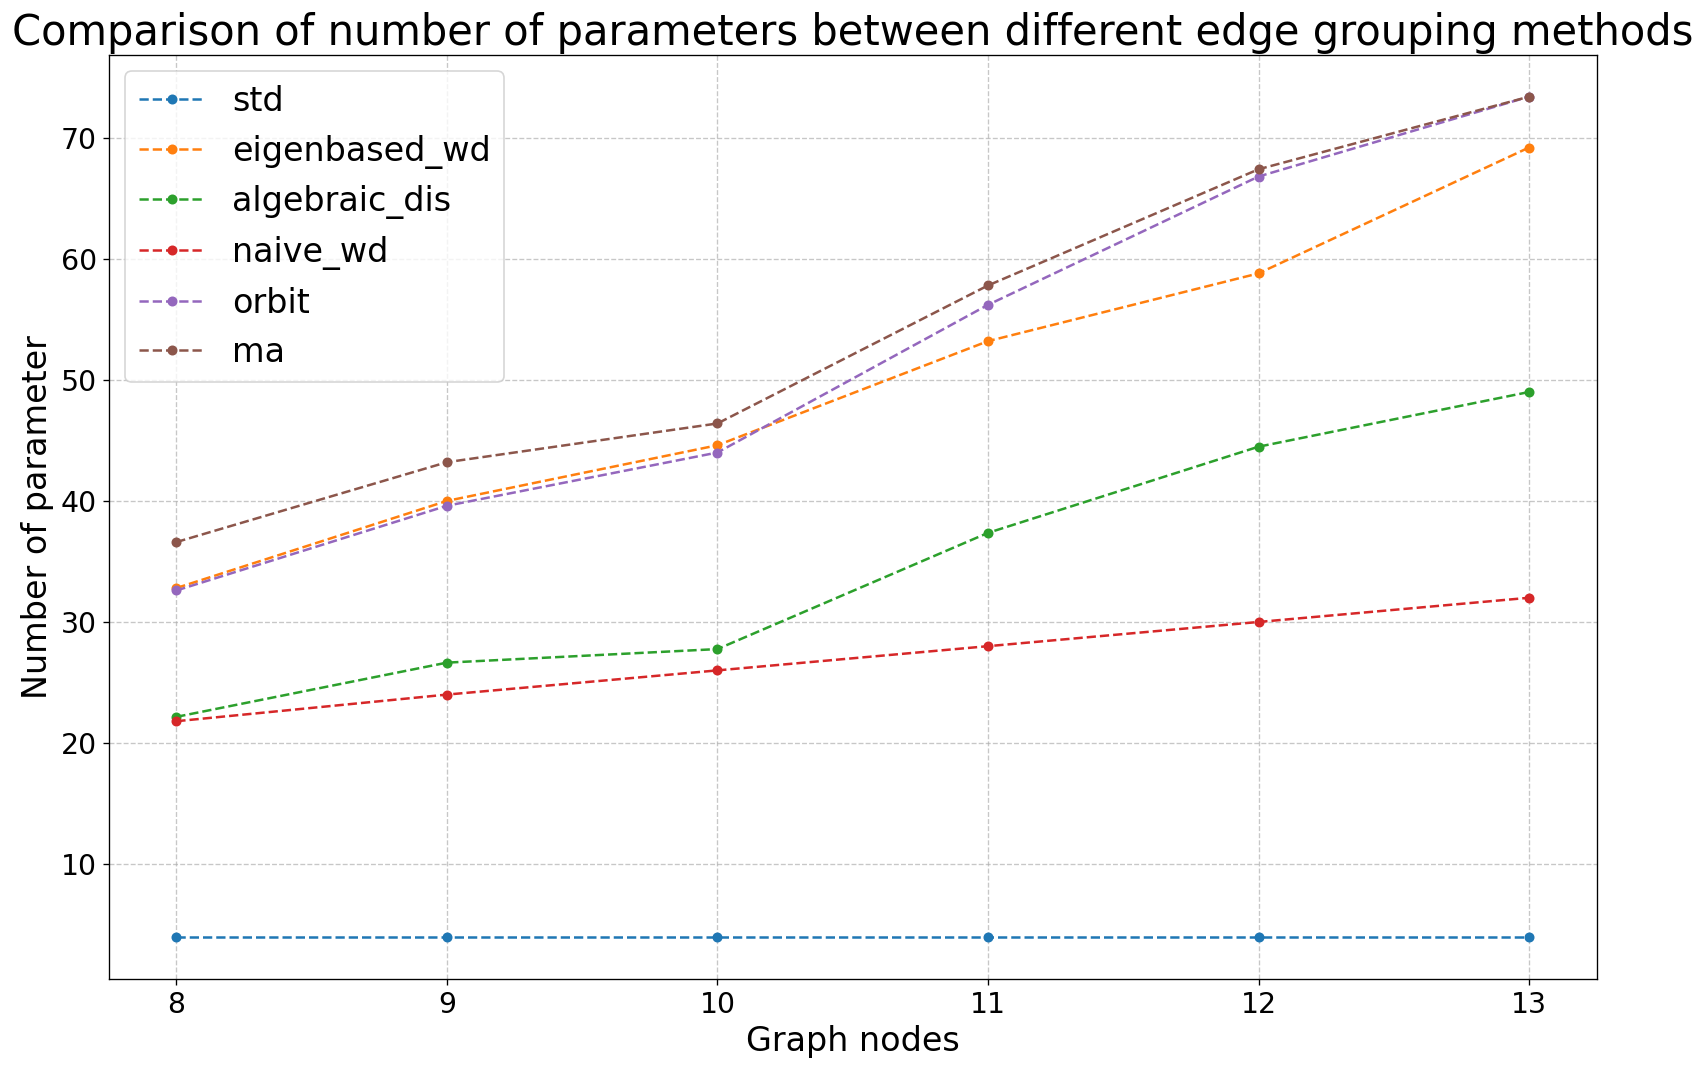

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists:#method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(random_weighted_numparams[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)

# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Number of parameter', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
plt.title('Comparison of number of parameters between different edge grouping methods', fontsize="25")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')

#### Distributed weights graphs

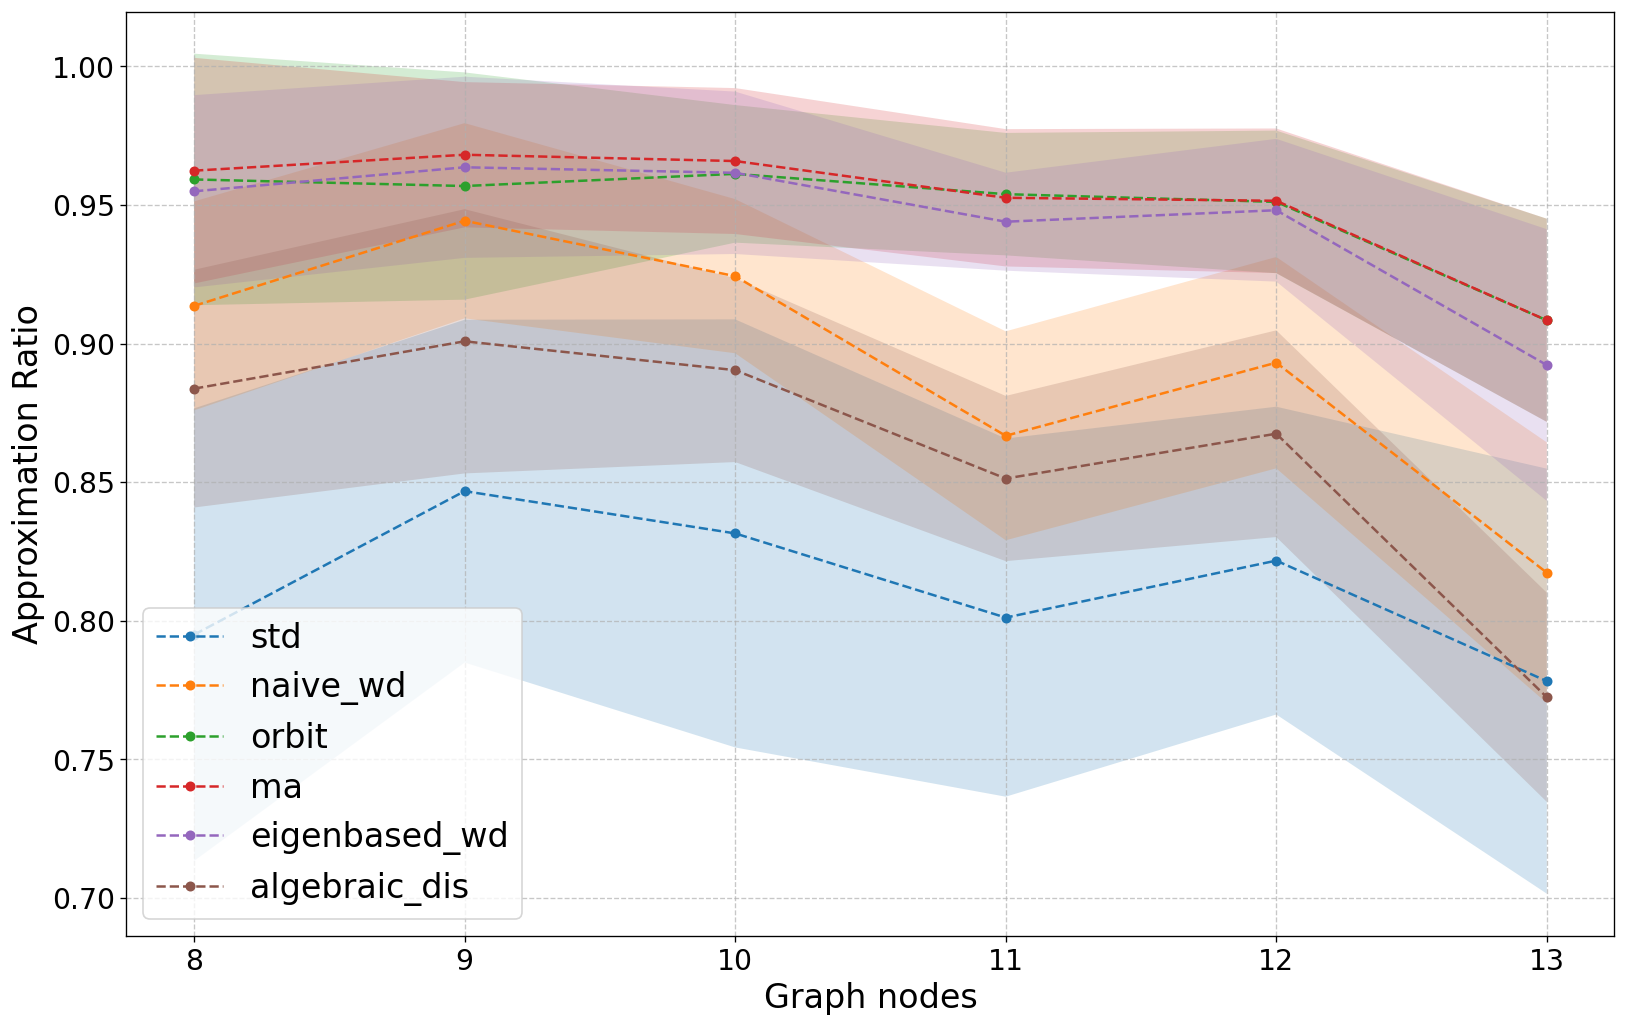

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(random_weighted_objvals[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)
    plt.fill_between(x, np.array(random_weighted_objvals[method])[:,0]-np.array(random_weighted_objvals[method])[:,1], np.array(random_weighted_objvals[method])[:,0]+np.array(random_weighted_objvals[method])[:,1],
    alpha=0.2, linewidth=4, linestyle='dashdot', antialiased=True)
# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Approximation Ratio', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
#plt.title('MLQAOA runtime between different subproblem scheme', fontsize="20")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')

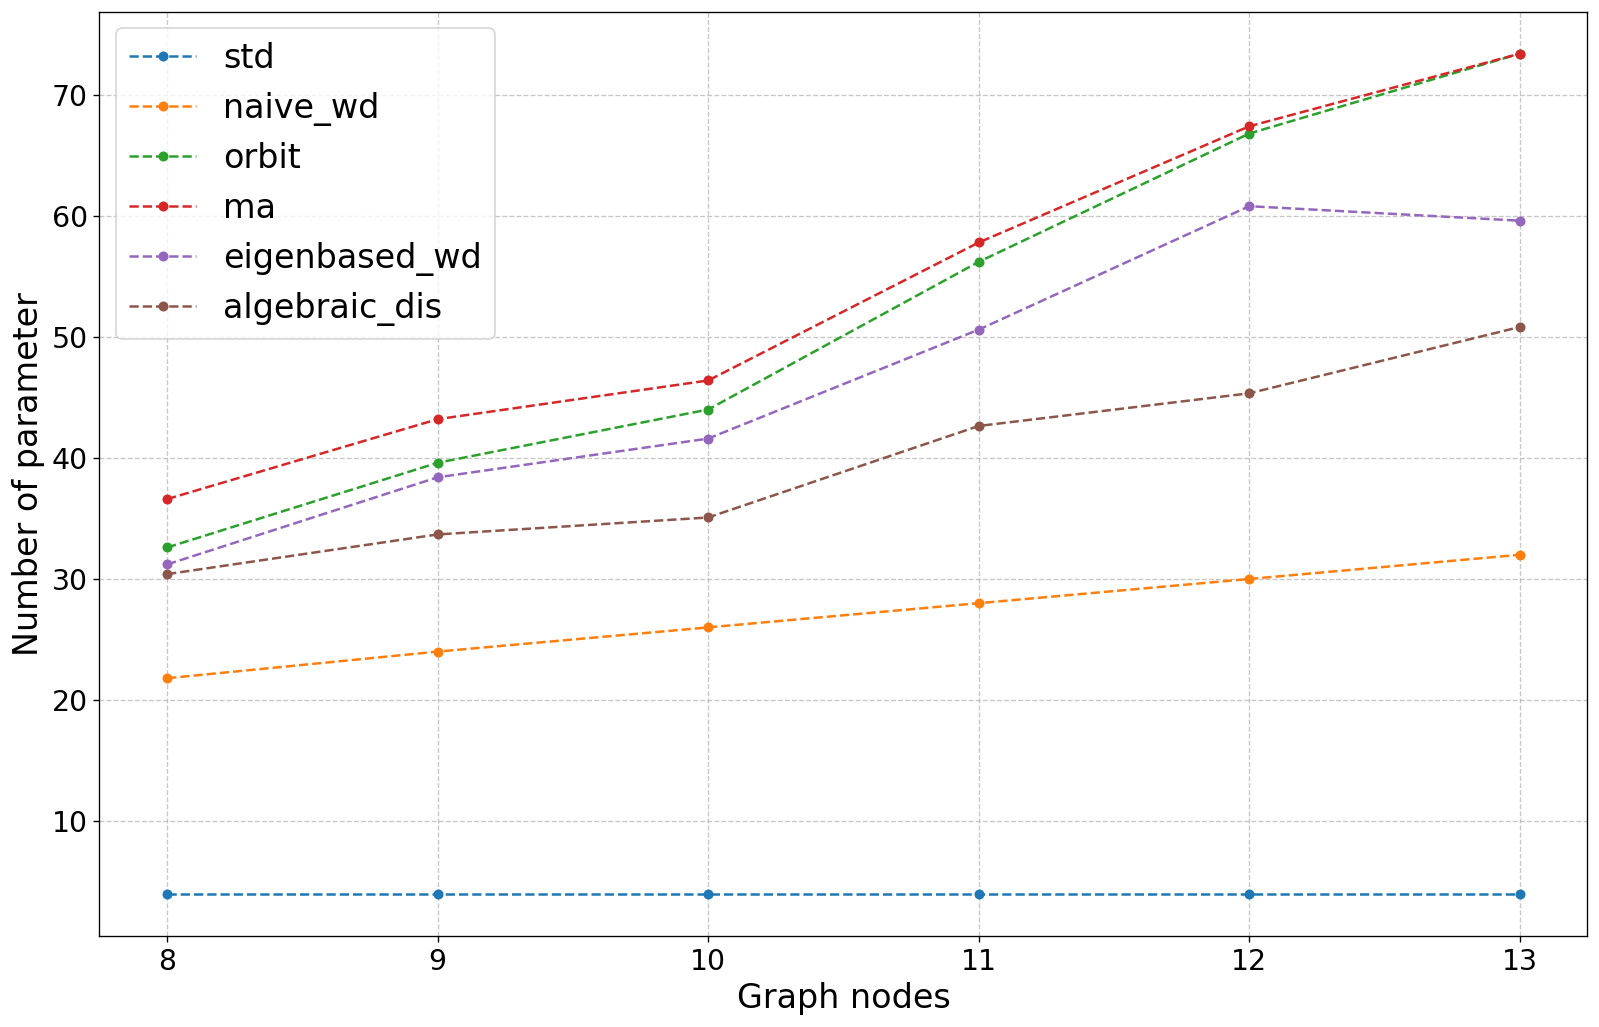

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

f = plt.figure(figsize=(16, 10), dpi=120)
x = range(8, 14)

for method in method_lists_old + method_lists_proposed:
    plt.plot(x, np.array(random_weighted_numparams[method])[:,0], label=method,marker='o', linestyle='--', markersize=5)
    #plt.errorbar(x, np.array(unweighted_objvals[method])[:,0], yerr=np.array(unweighted_objvals[method])[:,1], fmt='o', linestyle='--', markersize=5, capsize=4)

# plt.plot(x, updated_qiro_mean, label=f'updated MLQAOA \nQIRO-RQAOA', color='#1E0342',marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_qiro_mean, yerr=updated_qiro_std, fmt='o', linestyle='--', color='#1E0342', markersize=5, capsize=4)

# plt.plot(x, updated_param_mean, label=f'updated MLQAOA \nParameter Transfer', color = '#E4C59E', marker='o', linestyle='--', markersize=5)
# plt.errorbar(x, updated_param_mean, yerr=updated_param_std, fmt='o', linestyle='--', color='#E4C59E', markersize=5, capsize=4)

#Add a grid
plt.grid(True)
# Set labels for the axes
plt.xlabel('Graph nodes', fontsize="20")
plt.ylabel('Number of parameter', fontsize="20")
# Setting y-axis scale to logarithmic for better visualization of large values
#ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.gca().yaxis.set_ticks([400, 500, 600, 700, 800, 900, 1000, 2000, 3000])

#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#plt.gca().xaxis.set_ticks([3e4, 4e4, 6e4, 1e5, 2e5, 3e5, 4e5, 6e5, 1e6, 2e6, 3e6])
#plt.gca().xaxis.get_offset_text().set_fontsize(17)

plt.yticks(fontsize="17")
plt.xticks(fontsize="17")

#plt.axhline(y = 1, color = 'black', linestyle = '-', label='Best solution from classical solvers') 

# Set a title for the chart
#plt.title('MLQAOA runtime between different subproblem scheme', fontsize="20")

# Add a legend (optional)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize="20")

# Display the chart
plt.show()
plt.tight_layout()
#f.savefig("runtime.pdf", bbox_inches='tight')